<a href="https://colab.research.google.com/github/leoliuuu/MovieRecommendation/blob/main/Complete_Project_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation with Movielens Dataset


# Installing Dependencies and Dataset

In [ ]:
!pip install fuzzywuzzy
import os, gdown, warnings,os, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
warnings.filterwarnings('ignore')

In [ ]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1oP_H072BGA1KSuY-PbwlYkTaEFE1W3eP&export=download', 'ml-latest-small.zip', quiet=False)
!unzip -qq ml-latest-small.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1oP_H072BGA1KSuY-PbwlYkTaEFE1W3eP&export=download
To: /content/ml-latest-small.zip
100%|██████████| 978k/978k [00:00<00:00, 58.0MB/s]


replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
data_path = "ml-latest-small/"

df_ratings = pd.read_csv(
    os.path.join(data_path, 'ratings.csv'),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

df_movies = pd.read_csv(
    os.path.join(data_path,'movies.csv'),
    usecols=['movieId','title'],
    dtype={'movieId':'int32','title':'str'})

#merge two files into one so that the rating list will have the movie names attached to it
df_full_movie = pd.merge(df_ratings,df_movies, on="movieId")

# Exploratory Analysis

In order to build any models on a dataset, it is important to take a look at the dataset and gain as much understanding as I could through some exploratory analysis.

In [ ]:
# I first want to see the list of the movies with the highest average rating.
df_full_movie.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Sorority House Massacre (1986)                   5.0
Bill Hicks: Revelations (1993)                   5.0
My Man Godfrey (1957)                            5.0
Hellbenders (2012)                               5.0
In the blue sea, in the white foam. (1984)       5.0
Name: rating, dtype: float32

In [ ]:
# The list of the movies with the most ratings
df_full_movie.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [ ]:
n_users = len(df_ratings.userId.unique())
n_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this dataset'.format(n_users, n_items))

There are 610 unique users and 9724 unique movies in this dataset


In [ ]:
average_rating = df_full_movie['rating'].mean()

print('The average ratings across movies on a scale of 5 is', round(average_rating,4))

The average ratings across movies on a scale of 5 is 3.5016


In [ ]:
# get counts based off the movies
df_movie_ratings_count = pd.DataFrame(df_full_movie.groupby('title')['rating'].mean())
df_movie_ratings_count['rating_counts'] = pd.DataFrame(df_full_movie.groupby('title')['rating'].count())
print(df_movie_ratings_count)

                                             rating  rating_counts
title                                                             
'71 (2014)                                 4.000000              1
'Hellboy': The Seeds of Creation (2004)    4.000000              1
'Round Midnight (1986)                     3.500000              2
'Salem's Lot (2004)                        5.000000              1
'Til There Was You (1997)                  4.000000              2
...                                             ...            ...
eXistenZ (1999)                            3.863636             22
xXx (2002)                                 2.770833             24
xXx: State of the Union (2005)             2.000000              5
¡Three Amigos! (1986)                      3.134615             26
À nous la liberté (Freedom for Us) (1931)  1.000000              1

[9719 rows x 2 columns]


In [ ]:
# get counts based off the ratings
df_ratings_count = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_count

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [ ]:
 # there should be a lot more counts in rating of zero
total_count = n_users * n_items
rating_zero_count = total_count - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_count = df_ratings_count.append(
    pd.DataFrame({'count': rating_zero_count}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_count

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [ ]:
# Since the count is so different across ratings, we can add a log count to it
df_ratings_count['log_count'] = np.log(df_ratings_count['count'])
df_ratings_count

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


### Visulization of the Datase

Text(0, 0.5, 'number of ratings')

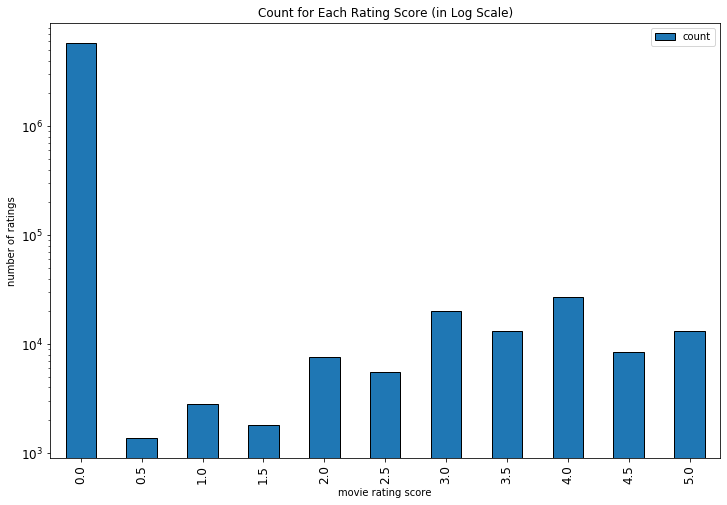

In [ ]:
#rating counts vs. rating score chart
ax = df_ratings_count[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings')

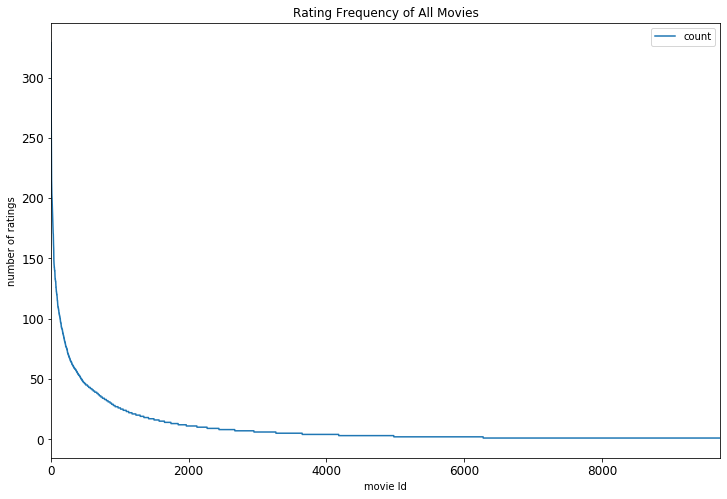

In [ ]:
# Rating frequency
df_movies_count = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_count.head()

# plot rating frequency of all movies
ax = df_movies_count \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

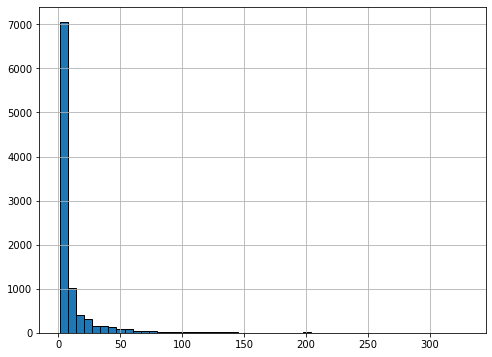

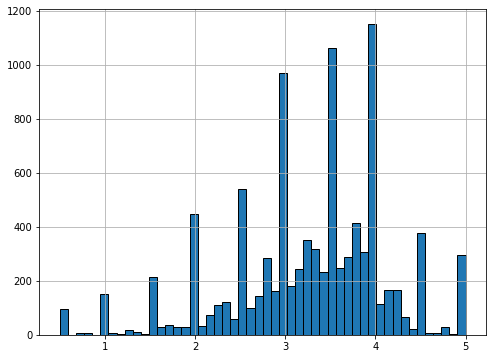

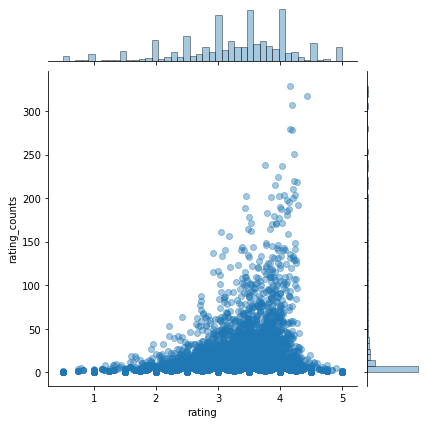

In [ ]:
#scatter plot of rating score and rating counts
%matplotlib inline

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
df_movie_ratings_count['rating_counts'].hist(bins=50)

plt.figure(figsize=(8,6))
df_movie_ratings_count['rating'].hist(bins=50)

sns.jointplot(x='rating', y='rating_counts', data=df_movie_ratings_count, alpha=0.4)

# Memory based Recommender

First, I will use the correlation between the ratings of a movie as the similarity metric. To find the correlation between the ratings of the movie, I need to create a matrix where each column is a movie name and each row contains the rating assigned by a specific user to that movie. However, this matrix will also have a lot of null values since every movie is not rated by every user.

In [ ]:
# create the pivot table
df_user_movie_rating = df_full_movie.pivot_table(index='userId', columns='title', values='rating')
df_user_movie_rating.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# For this correlation test, I will use one of my favorite movie "Forrest Gump."
forrest_gump_ratings = df_user_movie_rating['Forrest Gump (1994)']
forrest_gump_ratings.head()

userId
1    4.0
2    NaN
3    NaN
4    NaN
5    NaN
Name: Forrest Gump (1994), dtype: float32

In [ ]:
# movies with highest correlated rating score
movies_like_forrest_gump = df_user_movie_rating.corrwith(forrest_gump_ratings)

corr_forrest_gump = pd.DataFrame(movies_like_forrest_gump, columns=['Correlation'])
corr_forrest_gump.dropna(inplace=True)
corr_forrest_gump.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Lost & Found (1999),1.0
"Century of the Self, The (2002)",1.0
The 5th Wave (2016),1.0
Play Time (a.k.a. Playtime) (1967),1.0
Memories (Memorîzu) (1995),1.0
Playing God (1997),1.0
Killers (2010),1.0
"Girl Walks Home Alone at Night, A (2014)",1.0
Tampopo (1985),1.0


In [ ]:
# However, this could be a bit biased especially if a movie has low number of rating counts. To avoid this, we can set a threshold for the rating counts.
corr_forrest_gump = corr_forrest_gump.join(df_movie_ratings_count['rating_counts'])
corr_forrest_gump.head()

,Correlation,rating_counts
title,,
"'burbs, The (1989)",0.197712,17
(500) Days of Summer (2009),0.234095,42
*batteries not included (1987),0.892710,7
...And Justice for All (1979),0.928571,3
10 Cent Pistol (2015),-1.000000,2


In [ ]:
# List of highly correlated movies with at least 70 ratings
corr_forrest_gump[corr_forrest_gump['rating_counts']>70].sort_values('Correlation', ascending=False).head(20)

,Correlation,rating_counts
title,,
Forrest Gump (1994),1.000000,329
Mr. Holland's Opus (1995),0.652144,80
Big (1988),0.492351,91
Good Will Hunting (1997),0.484042,141
Aladdin (1992),0.464268,183
"Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)",0.461204,72
American History X (1998),0.457287,129
Contact (1997),0.438597,82
"Truman Show, The (1998)",0.432556,125


#KNN Recommender

In [ ]:
# filter data
popularity_thres = 70
popular_movies = list(set(df_movies_count.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

# get number of ratings given by every user
df_users_count = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_count.head()

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (3998, 3)


,count
userId,
1,12
4,8
5,3
6,29
7,5


In [ ]:
# filter data
ratings_thres = 70
active_users = list(set(df_users_count.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (195, 3)


In [ ]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [ ]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model based off cosine similarity
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = 'Forrest Gump'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Forrest Gump
Found possible matches in our database: ['Forrest Gump (1994)']

Recommendation system start to make inference
......

Recommendations for Forrest Gump:
1: Indiana Jones and the Last Crusade (1989), with distance of 0.0013123750686645508
2: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance of 0.0013123750686645508
3: Snow White and the Seven Dwarfs (1937), with distance of 0.0013123750686645508
4: One Flew Over the Cuckoo's Nest (1975), with distance of 0.0013123750686645508
5: Rock, The (1996), with distance of 0.0005370378494262695
6: Mission: Impossible II (2000), with distance of 0.0005370378494262695
7: City of God (Cidade de Deus) (2002), with distance of 0.0002702474594116211
8: What's Eating Gilbert Grape (1993), with distance of 0.0
9: Monty Python's Life of Brian (1979), with distance of 0.0
10: Forrest Gump (1994), with distance of 0.0


# Generalized Matrix Factorization

In [ ]:
# Dimensional Space Reduction for matrix factorization

def reduce_item_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['userId', 'movieId', 'rating']
    output: pd.DataFrame, df_ratings with new 'MovieID' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='userId', columns='movieId', values='rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('userId') \
        .melt(
            id_vars='userId', 
            value_vars=df_user_item.columns,
            var_name='movieId',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['userId', 'movieId']).reset_index(drop=True)

In [ ]:
print('reduce item dimension before:')
df_ratings.head()

reduce item dimension before:


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
df_ratings = reduce_item_dim(df_ratings)

print('reduce item dimension after:')
df_ratings.head()

reduce item dimension after:


,userId,movieId,rating
0,1,0,4.0
1,1,2,4.0
2,1,5,4.0
3,1,43,5.0
4,1,46,5.0


In [ ]:
# train/test data split

df_train, df_test = train_test_split(df_ratings,test_size=0.3,shuffle=True, random_state = 88)
print('shape of training data set:', df_train.shape)
print('shape of test data set:', df_test.shape)

shape of training data set: (70585, 3)
shape of test data set: (30251, 3)


In [ ]:
def get_GMF_model(n_users, n_items, latent_dim, vu_reg, vi_reg):   
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=n_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=n_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=os.path.join(data_path, '/tmp/model.hdf5'),
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

In [ ]:
# Create GMF Model

GMF_model = get_GMF_model(n_users,n_items,10,0,0)
GMF_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        6110        user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        97250       item_input[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Train GMF Model

# model config
batch_size = 64
epochs =30
val_split = 0.25

#train model
history = train_model(GMF_model,'adam',batch_size, epochs, val_split,
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 52938 samples, validate on 17647 samples
Epoch 1/30
52938/52938 [==============================] - 5s 91us/sample - loss: 0.5968 - mean_squared_error: 0.5968 - rmse: 0.7673 - val_loss: 1.0546 - val_mean_squared_error: 1.0546 - val_rmse: 1.0214
Epoch 2/30
52938/52938 [==============================] - 5s 86us/sample - loss: 0.5673 - mean_squared_error: 0.5673 - rmse: 0.7480 - val_loss: 1.0470 - val_mean_squared_error: 1.0470 - val_rmse: 1.0176
Epoch 3/30
52938/52938 [==============================] - 5s 89us/sample - loss: 0.5403 - mean_squared_error: 0.5403 - rmse: 0.7299 - val_loss: 1.0463 - val_mean_squared_error: 1.0463 - val_rmse: 1.0163
Epoch 4/30
52938/52938 [==============================] - 5s 86us/sample - loss: 0.5163 - mean_squared_error: 0.5163 - rmse: 0.7127 - val_loss: 1.0546 - val_mean_squared_error: 1.0546 - val_rmse: 1.0211
Epoch 5/30
52938/52938 [==============================] - 5s 86us/sample - loss: 0.4934 - mean_squared_error: 0.4934 - rmse: 0.6972 - val_

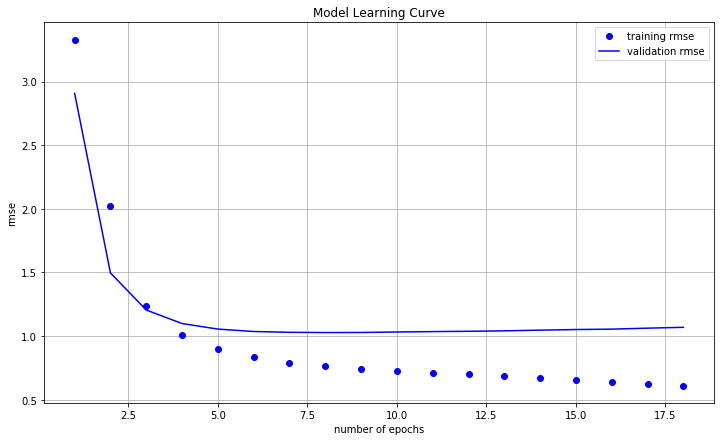

In [ ]:
# GMF Learning Curve

def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_learning_curve(history,'rmse')

In [ ]:
# Model Testing

rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(df_test.rating.values))))

# load best model
GMF_model = get_GMF_model(n_users, n_items, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, os.path.join(data_path, '/tmp/model.hdf5'))
# make prediction using test data
predictions = GMF_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The best RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.0335


# Multi-Layer Perceptron

In [ ]:
# define MLP model architecture

def get_MLP_model(n_users, n_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=n_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=n_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

In [ ]:
# create MLP model

MLP_model = get_MLP_model(n_users, n_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        19552       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        311200      item_input[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Train MLP Model

# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 56720 samples, validate on 18907 samples
Epoch 1/30
56720/56720 [==============================] - 6s 109us/sample - loss: 1.7356 - mean_squared_error: 1.7356 - rmse: 1.1420 - val_loss: 0.7887 - val_mean_squared_error: 0.7887 - val_rmse: 0.8833
Epoch 2/30
56720/56720 [==============================] - 6s 97us/sample - loss: 0.7238 - mean_squared_error: 0.7238 - rmse: 0.8455 - val_loss: 0.7707 - val_mean_squared_error: 0.7707 - val_rmse: 0.8739
Epoch 3/30
56720/56720 [==============================] - 5s 94us/sample - loss: 0.6712 - mean_squared_error: 0.6712 - rmse: 0.8142 - val_loss: 0.7651 - val_mean_squared_error: 0.7651 - val_rmse: 0.8693
Epoch 4/30
56720/56720 [==============================] - 5s 96us/sample - loss: 0.6350 - mean_squared_error: 0.6350 - rmse: 0.7920 - val_loss: 0.7639 - val_mean_squared_error: 0.7639 - val_rmse: 0.8680
Epoch 5/30
56720/56720 [==============================] - 5s 95us/sample - loss: 0.5999 - mean_squared_error: 0.5999 - rmse: 0.7691 - val

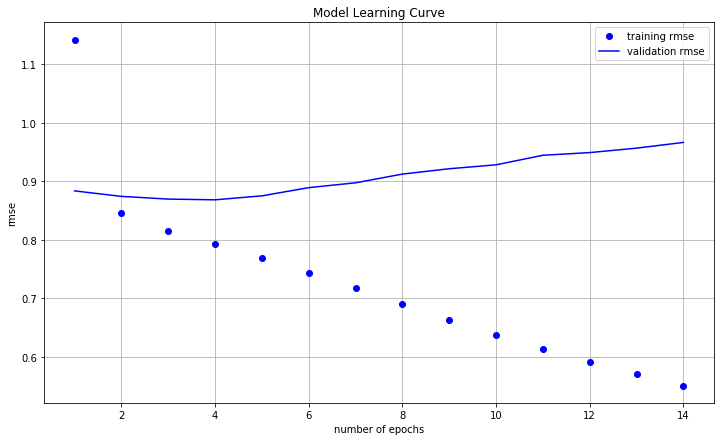

In [ ]:
# MLP Learning Curve

plot_learning_curve(history,'rmse')

In [ ]:
#MLP Model Testing

# load best model
MLP_model = get_MLP_model(n_users, n_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, os.path.join(data_path, '/tmp/model.hdf5'))
# make prediction using test data
predictions = MLP_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The best RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8818


# Neural Matrix Factorization (NeuMF)

In [ ]:
# define NeuMF model architecture

def get_NeuMF_model(n_users, n_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    n_users: int, total number of users
    n_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=n_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=n_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=n_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=n_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

In [ ]:
# Create NeuMF Model
NeuMF_model = get_NeuMF_model(
    n_users=n_users,
    n_items=n_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        19552       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        311200      item_input[0][0]                 
___________________________________________________________________________________________

In [ ]:
#Train NeuMF model
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 56720 samples, validate on 18907 samples
Epoch 1/30
56720/56720 [==============================] - 7s 125us/sample - loss: 1.8394 - mean_squared_error: 1.8394 - rmse: 1.1616 - val_loss: 0.7944 - val_mean_squared_error: 0.7944 - val_rmse: 0.8866
Epoch 2/30
56720/56720 [==============================] - 6s 110us/sample - loss: 0.7230 - mean_squared_error: 0.7230 - rmse: 0.8454 - val_loss: 0.7705 - val_mean_squared_error: 0.7705 - val_rmse: 0.8734
Epoch 3/30
56720/56720 [==============================] - 6s 108us/sample - loss: 0.6023 - mean_squared_error: 0.6023 - rmse: 0.7710 - val_loss: 0.7711 - val_mean_squared_error: 0.7711 - val_rmse: 0.8734
Epoch 4/30
56720/56720 [==============================] - 6s 113us/sample - loss: 0.4595 - mean_squared_error: 0.4595 - rmse: 0.6725 - val_loss: 0.8174 - val_mean_squared_error: 0.8174 - val_rmse: 0.8990
Epoch 5/30
56720/56720 [==============================] - 6s 110us/sample - loss: 0.3714 - mean_squared_error: 0.3714 - rmse: 0.6041 -

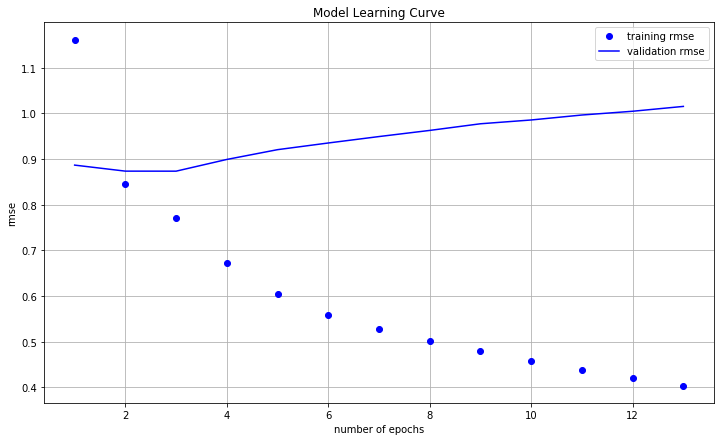

In [ ]:
# NeuMF Learning Curve
plot_learning_curve(history,'rmse')

In [ ]:
#NeuMF Model Testing
# load best model
NeuMF_model = get_NeuMF_model(
    n_users=n_users,
    n_items=n_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model = load_trained_model(NeuMF_model, os.path.join(data_path, '/tmp/model.hdf5'))
# make prediction using test data
predictions = NeuMF_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The best RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8869
